# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: 
*   Your **student number**: 



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

(400, 2)
[[ 0.89763767  4.98363526]
 [ 1.07627418  4.68480619]
 [ 1.01618041  4.48527047]
 [ 0.96605783  4.53127837]
 [-0.08485299  4.5170764 ]
 [ 1.36225876  3.36141328]
 [-0.04749204  5.47425256]
 [ 1.17461613  4.87333521]
 [ 0.92204087  5.12434567]
 [ 1.73531678  4.43068554]]


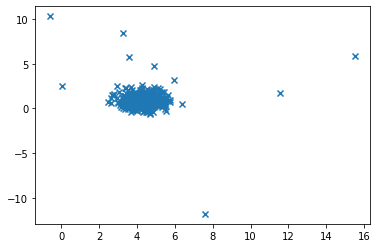

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
print(X.shape)
print(X[:10])
#print(y_true.shape)
#print(X_append.shape)
#print(X_append[:10])

X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [60]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X, axis = 0)
    mu = sum_/m
    
    # compute variance of X
    var = np.sum((X - mu)**2, axis = 0)/m

    
    return mu,var

print(X.shape)
mu, sigma = estimateGaussian(X)
print(mu,'\n',sigma)


(410, 2)
[4.30770882 0.9756171 ] 
 [0.94147734 1.25990509]


Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [61]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

print(p.shape)
print(p[:10])


(410,)
[0.11437256 0.13495896 0.14361205 0.14229909 0.09137122 0.08559413
 0.04682403 0.1213752  0.1024319  0.11528858]


Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

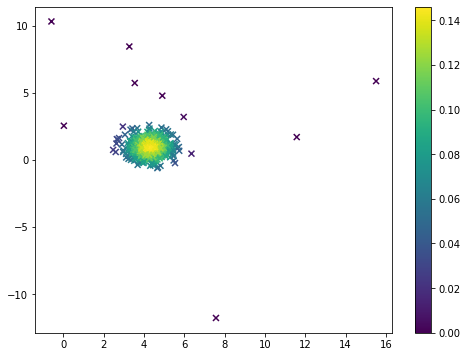

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [63]:
#Choose a value for epsilon
y_pred = np.empty(p.size, dtype = int)
epsilon = 0.02
print(p.size)



410


Now we'll highlight on the scatter plot all points that are below $\epsilon$:

10
[400 401 402 403 404 405 406 407 408 409]


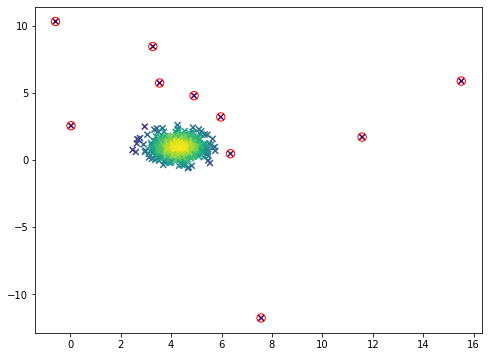

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
print(len(outliers))
print(outliers)
#plt.figure()
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get precision of 1.0? __10__
* What is the precision for K=4? __1__


recall for k=4 is **0.4**

In [65]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

max_k = 1
for i in range(0,50):
     mn = sorted(p)[i]
     sc = precision_score(y_true,1*(p<=mn))
     re = recall_score(y_true, 1*(p<=mn))

     if i == 3:
        print('K is ', i+1, '& Precision is ', sc, 'recall is ', re)
     
     
     
     if sc == 1 & ((i+1) > max_k):
        max_k = i+1
     print(sc)
        
print('highest value of K for which precision is 1: ', max_k)
print('alanyeung notes: precision_score dropping means more and more normal data are included into the score calcuation')

1.0
1.0
1.0
K is  4 & Precision is  1.0 recall is  0.4
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9090909090909091
0.8333333333333334
0.7692307692307693
0.7142857142857143
0.6666666666666666
0.625
0.5882352941176471
0.5555555555555556
0.5263157894736842
0.5
0.47619047619047616
0.45454545454545453
0.43478260869565216
0.4166666666666667
0.4
0.38461538461538464
0.37037037037037035
0.35714285714285715
0.3448275862068966
0.3333333333333333
0.3225806451612903
0.3125
0.30303030303030304
0.29411764705882354
0.2857142857142857
0.2777777777777778
0.2702702702702703
0.2631578947368421
0.2564102564102564
0.25
0.24390243902439024
0.23809523809523808
0.23255813953488372
0.22727272727272727
0.2222222222222222
0.21739130434782608
0.2127659574468085
0.20833333333333334
0.20408163265306123
0.2
highest value of K for which precision is 1:  10
alanyeung notes: precision_score dropping means more and more normal data are included into the score calcuation


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

(301, 2)
(149, 2)


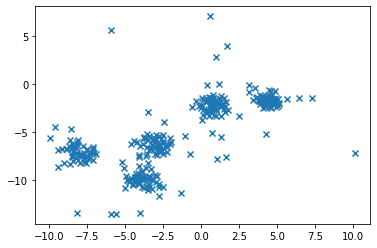

In [66]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

print(X_train.shape)
print(X_test.shape)

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? _**1**__
* k=10?  **0.9**___
* k=100? **0.13**___

recall for 
k = 1? **0.056**
k = 10? **0.5**
k =100? **0.722**

9
For K= -1 ,precision is:  1.0 and recall is 0.05555555555555555
For K= 8 ,precision is:  0.9 and recall is 0.5
For K= 98 ,precision is:  0.13 and recall is 0.7222222222222222


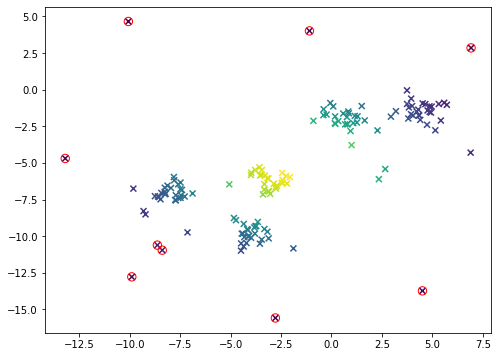

In [67]:
mu, sigma = estimateGaussian(X_train)

p = multivariateGaussian(X_test, mu, sigma)

plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
print(len(outliers))
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

#precision score
for i in range(0,100):
     mn = sorted(p)[i]
     sc = precision_score( y_test,1*(p<=mn))
     
     re = recall_score(y_test, 1*(p<=mn))
     
     if (i == 0) | (i ==9) | (i == 99):
        print('For K=',i-1, ',precision is: ', sc, 'and recall is', re)


      

Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [68]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)
#probability that a point belongs to specific cluster is given by gm.predict_proba()
gm.predict_proba(X_train)

array([[6.74869931e-059, 4.40166043e-009, 3.32032178e-011,
        9.99999996e-001, 3.18952155e-011],
       [1.93712936e-015, 1.29319813e-119, 9.99999997e-001,
        1.19215143e-009, 2.14816399e-009],
       [1.34738997e-013, 2.83317796e-056, 7.32070993e-004,
        9.42624363e-007, 9.99266986e-001],
       ...,
       [1.98450900e-062, 1.41218398e-007, 4.96241137e-012,
        9.99999859e-001, 1.32754039e-012],
       [1.59058143e-109, 9.99282358e-001, 1.74883538e-021,
        7.17641787e-004, 9.26527784e-034],
       [2.22050746e-101, 9.74932585e-001, 2.82750636e-020,
        2.50674150e-002, 3.62991363e-029]])

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

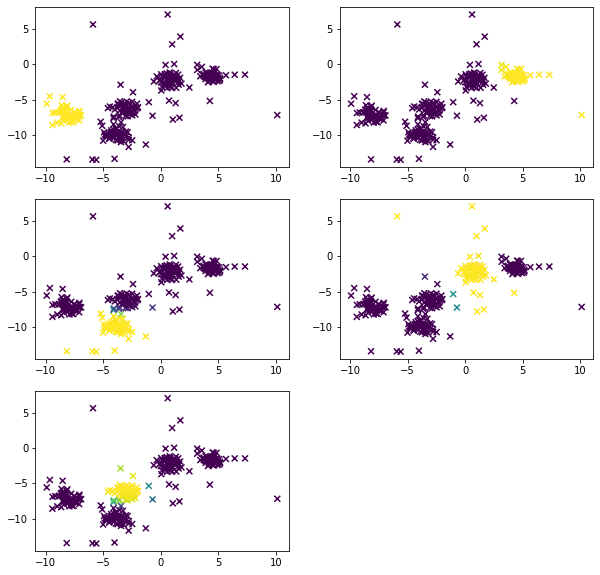

In [69]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100. 

Precision for k =1,10,100 are: **1,1, 0.18**

Recall for k =1,10,100 are: **0.056, 0.556, 1**

* Is this model better or worse performing than the previous? _**Better**__- **as seen in ROC - GMM (curve towards the perfect classifiction point(0,1). For better performance, TPR should be high and FPR should be low)**

* Why might that be? **With GMM, we are able to divide the data into clusters leading to better classification of data points**

In [70]:
#old code
'''ps = gm.predict_proba(X_test)
#product of probabilty of data point to be not in any of the 5 clusters
nic = 1-ps
g = np.prod(nic, axis = 1)

#probablity that data point is in one of the cluster

p_mog = 1 - g


for i in range(0,100):
     mn = sorted(p_mog)[i]
     sc = precision_score( y_test,1*(p_mog<=mn))
     
    
     print('K is', i+1, 'Precision is', sc)
'''

"ps = gm.predict_proba(X_test)\n#product of probabilty of data point to be not in any of the 5 clusters\nnic = 1-ps\ng = np.prod(nic, axis = 1)\n\n#probablity that data point is in one of the cluster\n\np_mog = 1 - g\n\n\nfor i in range(0,100):\n     mn = sorted(p_mog)[i]\n     sc = precision_score( y_test,1*(p_mog<=mn))\n     \n    \n     print('K is', i+1, 'Precision is', sc)\n"

(149,)
[-4.4264541  -3.86456602 -3.44194995 -4.26767819 -4.15749077 -3.16015248
 -4.91924544 -7.0864545  -4.1401459  -3.69100384]
For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000
[0.         0.         0.         0.02290076 0.02290076 0.16793893
 0.16793893 0.28244275 0.28244275 0.71755725 0.71755725 0.75572519
 0.75572519 0.76335878 0.76335878 0.79389313 0.79389313 1.        ]
[0.         0.05555556 0.5        0.5        0.61111111 0.61111111
 0.66666667 0.66666667 0.72222222 0.72222222 0.77777778 0.77777778
 0.83333333 0.83333333 0.88888889 0.88888889 1.         1.        ]


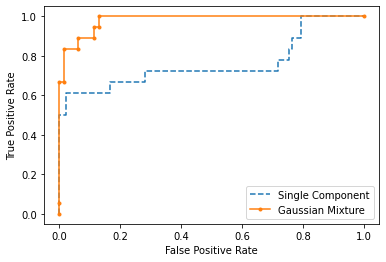

In [97]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample
print(p_gm.shape)
print(p_gm[:10])

for i in [1, 10, 100 ]: #Let's look at 3 different k values
    mn_gm = sorted(p_gm)[i-1] #We sort the points by probability, as before
    precision = precision_score(y_test, p_gm <= mn_gm) #Here, we compare y_test labels to our picks using precision
    recall = recall_score(y_test, p_gm <= mn_gm) #Here, we compare y_test labels to our picks using recall
    print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

print(fpr_sc)
print(tpr_sc)

Although our MoG model doesn't perfectly identify all the outliers, it performs way better than our previous model, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [72]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)




--2023-01-01 13:57:05--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2023-01-01 13:57:05--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle.1’

simpsons.pickle.1   100%[===================>]  25.46K  --.-KB/s    in 0.002s  

2023-01-01 13:57:05 (13.0 MB/s) - ‘simpsons.pickle.1’ saved [26076/26076]



In [73]:
#for keys, values in simpsons.iteritems():
print(simpsons.keys())
print(simpsons[1])

list_series = list(simpsons.keys())

list_series_ratings = list(simpsons.values())
#print(list_series_ratings)
ratings = []
for key,value in simpsons.items():
  for key1,value1 in value.items():
    ratings.append(value1)
print(ratings)



dict_keys([30, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32])
{'Simpsons Roasting on an Open Fire': 8.2, 'Bart the Genius': 7.8, "Homer's Odyssey": 7.4, "There's No Disgrace Like Home": 7.7, 'Bart the General': 8.1, 'Moaning Lisa': 7.6, 'The Call of the Simpsons': 7.8, 'The Telltale Head': 7.7, 'Life on the Fast Lane': 7.5, "Homer's Night Out": 7.4, 'The Crepes of Wrath': 7.8, 'Krusty Gets Busted': 8.4, 'Some Enchanted Evening': 7.8}
[6.2, 6.0, 6.1, 5.9, 7.0, 6.6, 5.8, 6.6, 6.8, 6.7, 5.7, 6.3, 6.9, 6.2, 6.4, 5.8, 6.3, 4.9, 6.2, 5.2, 5.3, 6.0, 5.9, 8.2, 7.8, 7.4, 7.7, 8.1, 7.6, 7.8, 7.7, 7.5, 7.4, 7.8, 8.4, 7.8, 8.2, 8.3, 8.3, 8.1, 7.5, 8.0, 7.8, 8.4, 8.1, 7.8, 8.8, 8.3, 8.0, 7.5, 8.3, 7.5, 7.6, 8.0, 8.5, 7.9, 8.3, 7.9, 8.6, 7.8, 8.2, 8.6, 8.5, 7.7, 8.3, 7.9, 7.9, 8.8, 8.3, 8.3, 8.5, 8.0, 8.1, 8.3, 8.7, 8.2, 7.8, 8.0, 8.3, 7.8, 7.8, 8.2, 8.5, 8.2, 9.0, 7.8, 8.5, 8.2, 7.9, 8.2, 8.8, 8.6, 8.7, 9.0, 8.0, 8.2, 8.4, 8.4, 9.

With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? _**7.1**_
* What is the range of ratings? _**5.3**_

model rating for simpsons is: 7.1
range of rating for simpsons is: 5.300000000000001


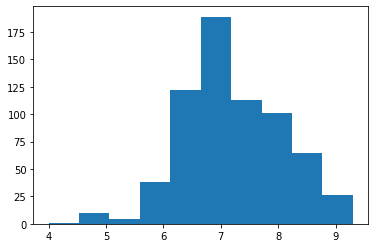

In [74]:
from statistics import mode #to find modal rating in simpsons rating
plt.hist(ratings, 10)
print("model rating for simpsons is:", mode(ratings))
print("range of rating for simpsons is:", max(ratings)-min(ratings))


Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? _**low rating cluster mean: 6.77; high rating cluster mean: 8.18**_
* What about the standard deviations? _**low rating cluster std: 0.597; high rating cluster std: 0.474**_

[[0.59689303 0.4741226 ]]
[[6.7734211  8.17942889]]
Standard Deviation:  [[0.59689303 0.4741226 ]] 
 Mean:  [[6.7734211  8.17942889]]


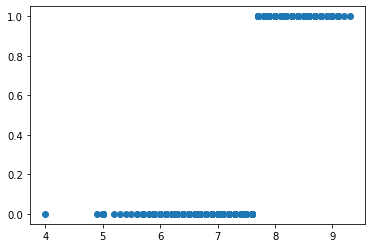

In [75]:
ratings_array = np.array(ratings)
t = ratings_array.reshape(-1,1)
gm_2 = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
gmm = gm_2.fit(t)
co = gmm.covariances_
std = np.sqrt(co).reshape(1,-1)
mean = gmm.means_.reshape(1,-1)
y_pred_simpsons = gm_2.predict(t)

print(std)
print(mean)

#plotting to know what does 0 and 1 mean in prediction data
plt.scatter(t, y_pred_simpsons)
print('Standard Deviation: ', std,'\n', 'Mean: ', mean)

In [76]:
print("from plot, 1 is for good and 0 for bad rating")
min_good = 10
for i in range(t.size):
  if y_pred_simpsons[i] == 1:
    if t[i] < min_good:
      min_good = t[i]

    
print("good rating starts from", min_good)


     

from plot, 1 is for good and 0 for bad rating
good rating starts from [7.7]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? **9th season (from 20 good episodes to 10 good episodes in 10th season)**__
* When is the first season with 0 good episodes? __**15**

[9, 18, 24, 21, 21, 24, 24, 24, 20, 10, 4, 5, 4, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0]
first season with zero good episode:  15


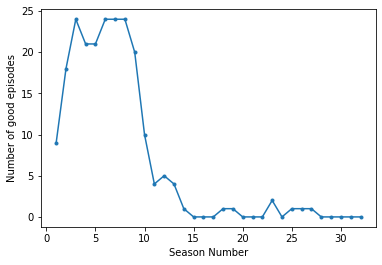

In [77]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
m = len(simpsons)
good_list = []
season_with_0_good = []

for keys, values in simpsons.items():
  good = 0
  for keys1, values1 in values.items():
    if values1 >= min_good:
      good += 1
  good_list.append(good)
  if good ==0:
    season_with_0_good.append(keys)
    

plt.plot(range(1,m+1), good_list,marker ='.')
plt.xlabel("Season Number")
plt.ylabel("Number of good episodes")
print(good_list)
print("first season with zero good episode: ", season_with_0_good[0])

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] _**284807**____
* What features in the dataset are present aside from the 28 main features?[1] _**Time, Amount**
* Why do you think the main features are given to us in this way?[1] __**To maintain the confidentiality of identies and other sensitive data (Original data might have been reduced to less number of features using PCA)**___
* Which column contains the targets? Can you figure out what the values correspond to?[1] __Class 1: Fraudulent, 0: non-Fraudulent___

In [78]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (1).gz'

In [80]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


number of rows in dataset:  284807
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101

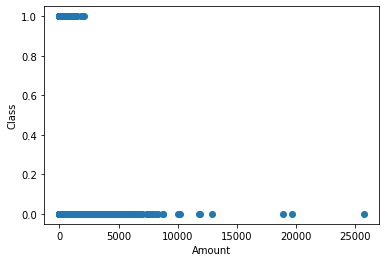

In [81]:
data = pd.read_csv('creditcard.csv')
print("number of rows in dataset: ", data.shape[0])
print(data.columns)
print(data.head())

plt.scatter(data['Amount'], data['Class'])
plt.xlabel('Amount')
plt.ylabel('Class')
plt.show()

It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] __0.17 % for class = 1 and 99.83 % for class 0___
* Why might this pose a problem with methods we have looked at so far?[1] _**There are very few datasets for fraud cases to train the model with methods covered earlier**____



In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
class_1 = len(data[data['Class']== 1])
class_0 = len(data[data['Class']== 0])
print("For class 1, percentage: ", (class_1)/(class_0+ class_1)*100)
print("For class 0, percentage: ", class_0/(class_0+class_1)*100)

For class 1, percentage:  0.1727485630620034
For class 0, percentage:  99.82725143693798


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] _ **Mean: 0.0004297, Standard Deviation: 0.60483**___

Use the code below to set up a Gaussian object for V24.

In [83]:

X_data = data.iloc[:, 1:30] # trim Time colume and class colume
print(data.shape)
print(X_data.shape)

y_data = data['Class']

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=1/3, random_state=0, shuffle = True)
#print(type(X_train_data))


(284807, 31)
(284807, 29)


In [84]:
from scipy import stats
mean = X_train_data['V24'].mean()
std = X_train_data['V24'].std()
print('Mean for V24 feature: ', mean,'\n','Standard deviation for V24 feature: ', std)

norm = stats.norm(mean, std)


Mean for V24 feature:  0.0004296701611641426 
 Standard deviation for V24 feature:  0.6048294388274772


1.4074733493347804


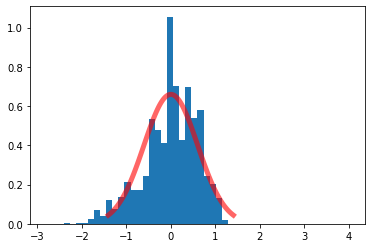

In [85]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
print(norm.ppf(0.99))
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train_data['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()


We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

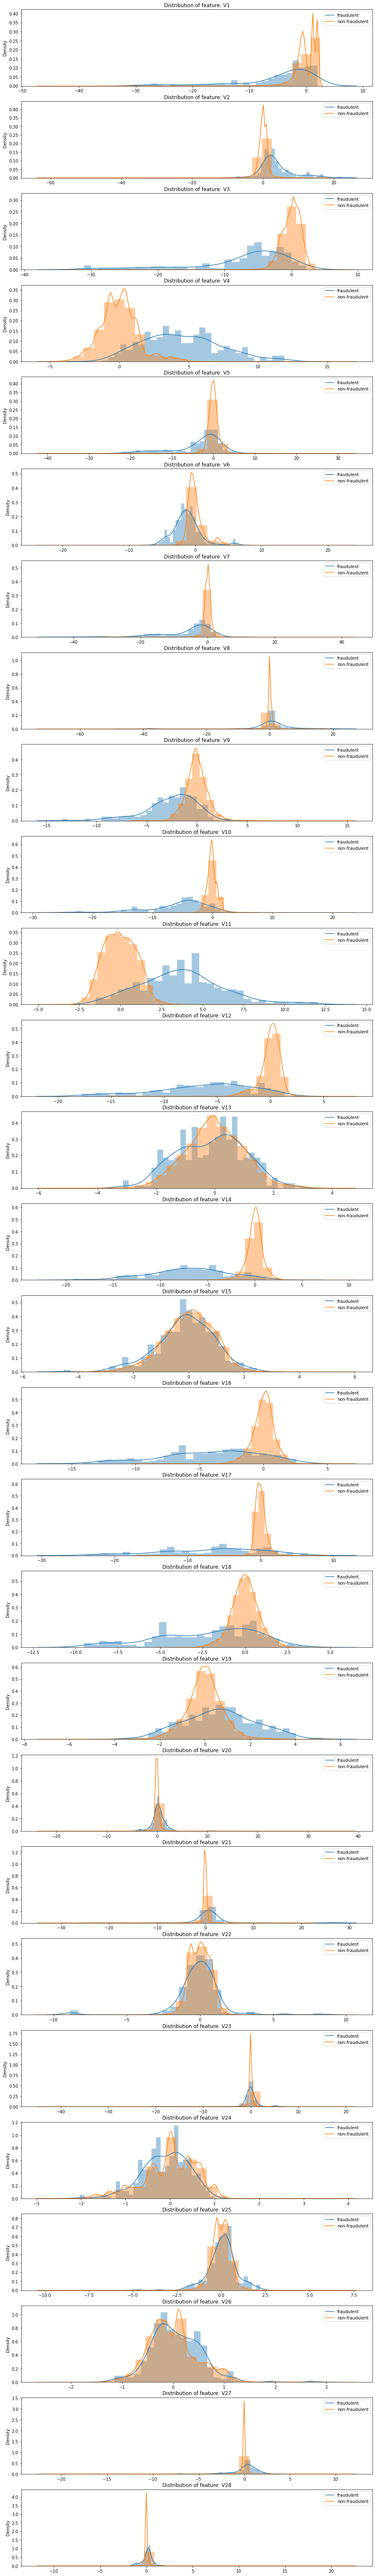

In [86]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in data.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train_data[feat][y_train_data==1], bins=30)
    sns.distplot(X_train_data[feat][y_train_data==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3]

**Answer begins here:**

Feature selection procedure:

*   Using plots above, Features chosen only if fraudulent data does not overlap with non-fraudulent (V3, V4, V10, V11, V12, V16, V17, V18, V19) 
*   Choose features with similar gaussian distribution

Cases considered:


1.   'V3', 'V4', 'V10', 'V11', 'V12', 'V16', 'V17', 'V18', 'V19'
2.   'V17', 'V19'
3.   'V11', 'V12', 'V14'
4.   'V17','V14', 'V12', 'V11', 'V19', 'V18'
5.   'V1', 'V2', 'V3'


The recall and precision for different number of clusters is tabulated after each code snippet. The highest recall for each subset of feature is reported. 

In the end, roc curve for each feature set is plotted and best case is reported

Answer continued in the end








In [87]:
def recall_precision(X_fit, X_sc):
  from sklearn.metrics import recall_score
  from sklearn.metrics import roc_curve
  m = X_fit.shape[1] #number of features considered
  # considering n_clusters in the data
  n_clusters = range(1,6)

  k = [1,10,100]

  #variables for best case for gaussian model
  max_sc_ex_r = 0
  k_max_r = 1
  best_cluster_no = 1

  #arrays to store precision and recall for different k's and number of clusters
  pr_array = np.zeros((len(k), len(n_clusters)), dtype = float)
  re_array = np.zeros((len(k), len(n_clusters)), dtype = float)
  for c, i in enumerate(n_clusters):
    gm_ex = GaussianMixture(n_components = i, covariance_type = 'full', random_state = 0)
    gmm_ex = gm_ex.fit(X_fit)
    p_gm_ex = gm_ex.score_samples(X_sc)

    for r, j in enumerate(k):
      mn_ex = sorted(p_gm_ex)[j-1]

      pr_array[r,c] = precision_score(y_test_data, 1*(p_gm_ex <= mn_ex))
      re_array[r,c] = recall_score(y_test_data, 1*(p_gm_ex <= mn_ex))

      if re_array[r,c] > max_sc_ex_r:
         max_sc_ex_r = re_array[r,c]
         k_max_r = j
         best_cluster_no = i
         best_p_gm_ex_2 = p_gm_ex

  #print("Recalls of features V17, V18, V19 with clusters 2-10 and k =1, 10, 100")
  pr_df1 = pd.DataFrame(data = pr_array, index = k, columns = n_clusters)
  re_df1 = pd.DataFrame(data = re_array, index = k, columns = n_clusters)
  display(re_df1)
  print('Best recall with number of clusters: ', best_cluster_no, 'for k: ', k_max_r, 'with recall score: ', max_sc_ex_r)
  fpr_gm_ex, tpr_gm_ex, _ = roc_curve(y_test_data, 1-best_p_gm_ex_2)
  return fpr_gm_ex, tpr_gm_ex

In [88]:
X_fit = X_train_data[['V3', 'V4', 'V10', 'V11', 'V12', 'V16', 'V17', 'V18', 'V19']]
X_sc = X_test_data[['V3', 'V4', 'V10', 'V11', 'V12', 'V16', 'V17', 'V18', 'V19']]
print('Case 1 \n', "Recalls of features 'V3', 'V4', 'V10', 'V11', 'V12', 'V16', 'V17', 'V18', 'V19' with clusters 1-5 and k =1, 10, 100")
f1, t1 = recall_precision(X_fit, X_sc)

Case 1 
 Recalls of features 'V3', 'V4', 'V10', 'V11', 'V12', 'V16', 'V17', 'V18', 'V19' with clusters 1-5 and k =1, 10, 100


,1,2,3,4,5
1,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.054878,0.054878,0.048780,0.048780,0.042683
100,0.451220,0.402439,0.329268,0.323171,0.317073


Best recall with number of clusters:  1 for k:  100 with recall score:  0.45121951219512196


In [89]:
X_fit = X_train_data[['V17', 'V19']]
X_sc = X_test_data[[ 'V17',  'V19']]
print('Case 2 \n', "Recalls of features 'V17',  'V19' with clusters 1-5 and k =1, 10, 100")
f2, t2 = recall_precision(X_fit, X_sc)

Case 2 
 Recalls of features 'V17',  'V19' with clusters 1-5 and k =1, 10, 100


,1,2,3,4,5
1,0.006098,0.006098,0.006098,0.000000,0.006098
10,0.060976,0.060976,0.060976,0.036585,0.048780
100,0.451220,0.475610,0.432927,0.304878,0.304878


Best recall with number of clusters:  2 for k:  100 with recall score:  0.47560975609756095


In [90]:
X_fit = X_train_data[['V11', 'V12', 'V14']]
X_sc = X_test_data[['V11', 'V12', 'V14']]
print('Case 3 \n', "Recalls of features 'V11', 'V12', 'V14' with clusters 1-5 and k =1, 10, 100")
f3, t3 = recall_precision(X_fit, X_sc)

Case 3 
 Recalls of features 'V11', 'V12', 'V14' with clusters 1-5 and k =1, 10, 100


,1,2,3,4,5
1,0.006098,0.006098,0.006098,0.006098,0.006098
10,0.060976,0.060976,0.060976,0.060976,0.060976
100,0.512195,0.487805,0.420732,0.408537,0.347561


Best recall with number of clusters:  1 for k:  100 with recall score:  0.5121951219512195


In [91]:
X_fit = X_train_data[['V17','V14', 'V12', 'V11', 'V19', 'V18']]
X_sc = X_test_data[['V17','V14', 'V12', 'V11', 'V19', 'V18']]
print('Case 4 \n', "Recalls of features 'V17','V14', 'V12', 'V11', 'V19', 'V18' with clusters 1-5 and k =1, 10, 100")
f4, t4 = recall_precision(X_fit, X_sc)

Case 4 
 Recalls of features 'V17','V14', 'V12', 'V11', 'V19', 'V18' with clusters 1-5 and k =1, 10, 100


,1,2,3,4,5
1,0.006098,0.006098,0.006098,0.006098,0.006098
10,0.060976,0.060976,0.060976,0.060976,0.060976
100,0.518293,0.457317,0.457317,0.475610,0.469512


Best recall with number of clusters:  1 for k:  100 with recall score:  0.5182926829268293


In [92]:
X_fit = X_train_data[['V1', 'V2', 'V3']]
X_sc = X_test_data[['V1', 'V2', 'V3']]
print('Case 5 \n', "Recalls of features 'V1', 'V2', 'V3' with clusters 1-5 and k =1, 10, 100")
f5, t5 = recall_precision(X_fit, X_sc)

Case 5 
 Recalls of features 'V1', 'V2', 'V3' with clusters 1-5 and k =1, 10, 100


,1,2,3,4,5
1,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.036585
100,0.109756,0.115854,0.134146,0.128049,0.176829


Best recall with number of clusters:  5 for k:  100 with recall score:  0.17682926829268292


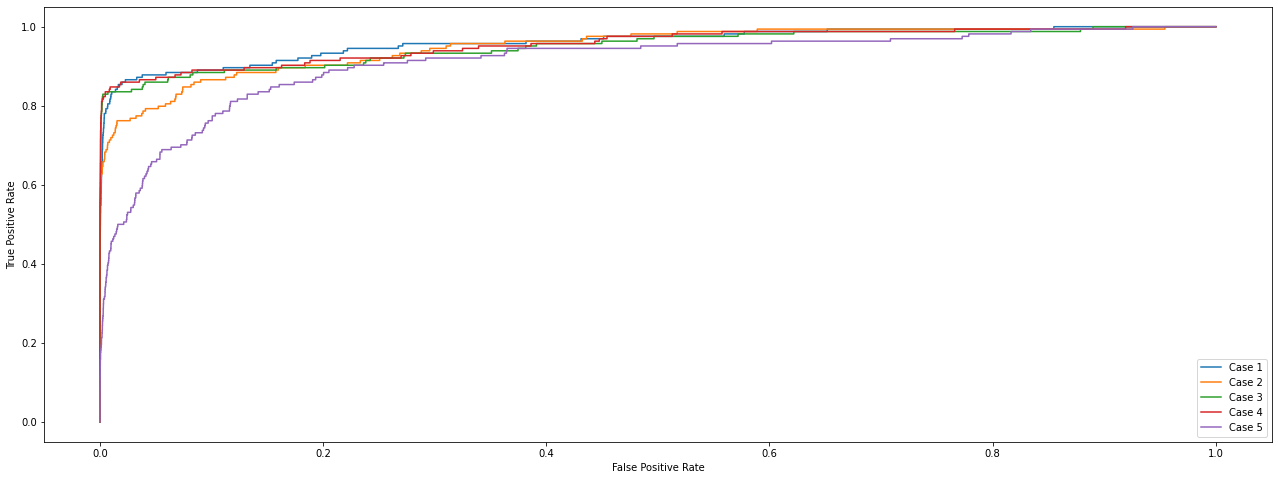

In [93]:
plt.figure(figsize = (22,8))
plt.plot(f1, t1, label='Case 1')
plt.plot(f2, t2,  label='Case 2')
plt.plot(f3, t3,  label='Case 3')
plt.plot(f4, t4,  label='Case 4')
plt.plot(f5, t5,  label='Case 5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In ROC graph, the ideal model should be L-shaped where point (0,1) depicts perfect classification.

Comparing the ROC curve graph, case 5 performs the worst while it's difficult to choose best case from rest of the cases. 

However, 

*   from the tabulated results in each case, features - ('V17','V14', 'V12', 'V11', 'V19', 'V18') give best recall score of 0.519 with number of cluster = 1 and k = 100
*   second best result is 0.512 with fetaures 'V11', 'V12', 'V14'with number of clusters = 1 and k = 100


